In [1]:
! git clone https://github.com/laxmimerit/twitter-data.git

Cloning into 'twitter-data'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


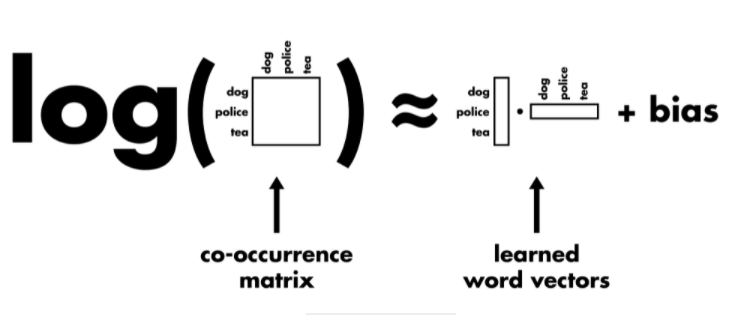

https://nlp.stanford.edu/projects/glove/

GloVe stands for global vectors for word representation. It is an unsupervised learning algorithm developed by Stanford for generating word embeddings by aggregating a global word-word co-occurrence matrix from a corpus. The resulting embeddings show interesting linear substructures of the word in vector space. This is occurence of a word in the whole document and not against the nereast once like in word 2 vec

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation, Dropout, Conv1D, GlobalMaxPooling1D, MaxPooling1D
import numpy as np
import pandas as pd
from numpy import array
from sklearn.model_selection import train_test_split
import itertools
import re
from tensorflow.keras.optimizers import Adam

In [3]:
df =pd.read_csv('/content/twitter-data/twitter4000.csv')

In [4]:
df.head()

,twitts,sentiment
0,is bored and wants to watch a movie any sugge...,0
1,back in miami. waiting to unboard ship,0
2,"@misskpey awwww dnt dis brng bak memoriessss, ...",0
3,ughhh i am so tired blahhhhhhhhh,0
4,@mandagoforth me bad! It's funny though. Zacha...,0


In [5]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

In [7]:
text = ' '.join(df['twitts'])
text = text.split()
freq_comm = pd.Series(text).value_counts()
rare = freq_comm[freq_comm.values == 1]

def get_clean_text(x):
    if type(x) is str:
        x = x.lower()
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        x = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', x) 
        #regex to remove to emails
        x = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x)
        #regex to remove URLs
        x = re.sub('RT', "", x)
        #substitute the 'RT' retweet tags with empty spaces
        x = re.sub('[^A-Z a-z]+', '', x)
        #combining all the text excluding rare words.
        x = ' '.join([t for t in x.split() if t not in rare])
        return x
    else:
        return x
    
df['twitts'] = df['twitts'].apply(lambda x: get_clean_text(x))  

In [8]:
df['twitts']

0       is bored and wants to watch a movie any sugges...
1                                back in miami waiting to
2       misskpey awwww dnt bak memoriessss i i am sad lol
3                                     ughhh i am so tired
4       mandagoforth me bad it is funny though zachary...
                              ...                        
3995                                               i just
3996               templating works it all has to be done
3997                      mommy just brought me starbucks
3998       omarepps watching you on a house rerunlovin it
3999    thanks for trying to make me smile i will make...
Name: twitts, Length: 4000, dtype: object

In [9]:
df['sentiment'].value_counts()

1    2000
0    2000
Name: sentiment, dtype: int64

In [10]:
text = df['twitts'].tolist()
text[:3]

['is bored and wants to watch a movie any suggestions',
 'back in miami waiting to',
 'misskpey awwww dnt bak memoriessss i i am sad lol']

In [11]:
y = df['sentiment']

In [12]:
token = Tokenizer()
token.fit_on_texts(text)

In [13]:
vocab_size  = len(token.word_index) + 1
vocab_size

6793

In [14]:
encoded_text = token.texts_to_sequences(text)

In [15]:
print(encoded_text[:3])

[[5, 279, 9, 315, 2, 182, 4, 217, 202, 2298], [48, 10, 1299, 183, 2], [2299, 1087, 655, 1300, 2300, 1, 1, 13, 114, 46]]


In [16]:
max_length = 120
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [17]:
X.shape

(4000, 120)

In [18]:
#declaring dict to store all the words as keys in the dictionary and their vector representations as values

glove_vectors = dict()

In [19]:
%%time
# file = open('glove.twitter.27B.200d.txt', encoding='utf-8')
file = open('/content/glove.twitter.27B.200d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    #storing the word in the variable
    vectors = np.asarray(values[1: ])
    #storing the vector representation of the respective word in the dictionary
    glove_vectors[word] = vectors
file.close()

CPU times: user 3.12 s, sys: 428 ms, total: 3.54 s
Wall time: 3.54 s


In [20]:
#printing length of glove vectors
len(glove_vectors)

78094

In [21]:
glove_vectors.get('aassrfdfa')

In [22]:
glove_vectors.get('you').shape

(200,)

Now we are creating a matrix for the tokens which we are having in our dataset and then storing their vector representation values in the matrix if it matches with glove_vectors words else print the misspelled words or words which are not present.

In [23]:
word_vector_matrix = np.zeros((vocab_size, 200))

for word, index in token.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector
    else:
        print(word)

sooo
awww
tommcfly
soooo
mileycyrus
ohhh
grrr
dougiemcfly
ddlovato
donniewahlberg
kirstiealley
quotthe
awwww
peterfacinelli
davidarchie
quoti
squarespace
youngq
jordanknight
ahhhhh
atampt
scrubbed
gtlt
hmmm
soooooo
songzyuuup
jayme
dannygokey
jackalltimelow
ashleytisdale
jonathanrknight
dky
ughhh
twitterberry
nkotb
theyr
misss
shaaqt
netra
rounders
cepic
soooooooooooo
spymaster
grrrr
methinks
mariahs
kevinjonas
notbut
recieved
musics
painkillers
sweetkisses
skp
dcdebbie
earthlifeshop
youquot
ltsobgt
wayyy
thatll
workno
unmotivated
heidimontag
mampg
boracay
seeee
sohotel
rachie
xbllygbsn
kieron
watchng
antsy
damohopo
bubs
jonasbrothers
twittered
katlb
anddd
lounging
rckergirl
mequot
quotyoure
aplusk
wwwtweeteraddercom
yelyahwilliams
paulgdog
hotwords
deltagoodrem
katz
miamiadc
dumbbell
trvsbrkr
changi
thesupergirl
gailporter
selenagomez
dwighthoward
virtualbox
twts
jeffreecuntstar
jobangels
youngcash
jazmine
misskpey
memoriessss
mandagoforth
huntingtons
kevinmarquis
peterfacinellis
rais

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

In [27]:
vec_size = 200

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length, weights = [word_vector_matrix], trainable = False))

model.add(Conv1D(64, 8, activation = 'relu'))
#here 64 is number of filters and 8 is size of filters
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 30, validation_data = (X_test, y_test))

Epoch 1/30
100/100 [==============================] - 7s 63ms/step - loss: 0.7531 - accuracy: 0.5031 - val_loss: 0.7171 - val_accuracy: 0.5025
Epoch 2/30
100/100 [==============================] - 6s 60ms/step - loss: 0.7223 - accuracy: 0.5200 - val_loss: 0.7067 - val_accuracy: 0.5075
Epoch 3/30
100/100 [==============================] - 6s 58ms/step - loss: 0.7045 - accuracy: 0.5347 - val_loss: 0.6961 - val_accuracy: 0.5275
Epoch 4/30
100/100 [==============================] - 6s 60ms/step - loss: 0.6980 - accuracy: 0.5337 - val_loss: 0.6909 - val_accuracy: 0.5362
Epoch 5/30
100/100 [==============================] - 6s 60ms/step - loss: 0.6862 - accuracy: 0.5591 - val_loss: 0.6832 - val_accuracy: 0.5512
Epoch 6/30
100/100 [==============================] - 6s 60ms/step - loss: 0.6854 - accuracy: 0.5641 - val_loss: 0.6748 - val_accuracy: 0.5800
Epoch 7/30
100/100 [==============================] - 6s 58ms/step - loss: 0.6716 - accuracy: 0.5863 - val_loss: 0.6681 - val_accuracy: 0.5975

In [28]:
def get_encode(x):
    x = get_clean_text(x)
    x = token.texts_to_sequences(x)
    x = pad_sequences(x, maxlen=max_length, padding='post')
    return x

In [29]:
get_encode(["i hi how are you isn't"])

array([[  1, 318,  77,  37,   7,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]], dtype=int32)

In [30]:
model.predict_classes(get_encode(['thank you for watching']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1]], dtype=int32)